## Initialize Pyspark

In [1]:
import findspark
findspark.init()
findspark.find()

'C:\\spark\\spark-3.5.2-bin-hadoop3'

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.sql import functions as F
# Ensure the correct import
from pyspark.sql.functions import col, when, count
from pyspark.sql.types import DoubleType

from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *

import os    

In [3]:
# Initialize Spark session      
appName = 'fifa' 
master = 'local'

conf = pyspark.SparkConf() \
    .set('spark.driver.host', '127.0.0.1') \
    .setAppName(appName) \
    .setMaster(master)
sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)

# to use the way of old version spark to deal with time format (Legacy) [1]
spark = SparkSession.builder \
    .config(conf=conf) \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Read data from PostgreSQL database

In [4]:
url = "jdbc:postgresql://localhost:5432/postgres"
properties = {
    "user": "postgres",
    "password": "user",
    "driver": "org.postgresql.Driver"
}

In [5]:
# read data from Postgres Table
players_df = spark.read.jdbc(url = url,table='fifa.players',properties = properties)

In [6]:
players_df_csv = players_df.toPandas().to_csv('players_df.csv', index=False, header=True)
players_df = spark.read.csv('players_df.csv', header=True, inferSchema=True)


## Data Cleaning

### Dealing with missing values

In [7]:
na_counts = players_df.select([count(when(col(c).isNull() | (col(c) == "NA"), c)).alias(c) for c in players_df.columns])
na_counts.show()

+---------+----------+----------+---------+----------------+-------+---------+---------+--------+---+---+---------+---------+------------+---------+-----------+------------+-------------+------------------+----------------+-----------+-------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+---------+---------+---------+------------------+-----------+-------------+-----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+------------------

### Thresholding: drop the columns that contains over 50% missing value

In [8]:
from pyspark.sql.functions import col, when, count

total_rows = players_df.count()
na_counts_df = players_df.select([count(when(col(c).isNull() | (col(c) == "NA"), c)).alias(c) for c in players_df.columns])
na_ratio = {c: na_counts_df.collect()[0][c] / total_rows for c in players_df.columns}
columns_to_drop = [c for c, ratio in na_ratio.items() if ratio > 0.5]
df_cleaned = players_df.drop(*columns_to_drop)

## Feature Selection and Engineering

### Select the column that are meaningful for the overall prediction

In [9]:
selected_columns = [
    "overall", "potential", "age", "height_cm", "weight_kg",
    "preferred_foot", "weak_foot", "skill_moves", "international_reputation", "pace", "shooting", "passing",
    "dribbling", "defending", "physic", "attacking_crossing", "attacking_finishing", "attacking_heading_accuracy",
    "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy",
    "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility",
    "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength",
    "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision",
    "mentality_penalties", "mentality_composure", "defending_marking_awareness", "defending_standing_tackle",
    "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking",
    "goalkeeping_positioning", "goalkeeping_reflexes", "ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam",
    "ram", "lm", "lcm", "cm", "rcm", "rm", "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk",
    "year", "gender"
]

df_selected = df_cleaned.select(*selected_columns)

# df_selected.show()

### Interpolate Null values with average value

In [10]:
null_list = ["pace", "shooting", "passing", "dribbling", "defending", "physic", "mentality_composure"]

df_interpolated = df_selected

for column in null_list:
    avg_value = df_interpolated.select(mean(col(column))).collect()[0][0]
    
    df_interpolated = df_interpolated.withColumn(
        column,
        when(col(column).isNull(), avg_value).otherwise(col(column)).cast('double')
    )

In [11]:
na_counts = df_interpolated.select([count(when(col(c).isNull() | (col(c) == "NA"), c)).alias(c) for c in df_interpolated.columns])
na_counts.show(vertical = True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 preferred_foot              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy           | 0   
 skill_long_passing          | 0   
 skill_ball_control          | 0   
 movement_acceleration       | 0   
 movement_sprint_speed      

In [12]:
df_interpolated.show()

+-------+---------+---+---------+---------+--------------+---------+-----------+------------------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----

### Convert the calculation (string dtype) into integer

In [13]:
# columns_to_convert = [
#     "ls", "st", "rs", 'lw', 'lf', 'cf', 'rf', 'rw', "lam", "cam", "ram", "lm", "lcm", "cm", "rcm", "rm", 
#     "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk"
# ]

# # 檢查是否包含 '+'，如果包含則拆分並進行加法計算，否則保留原值
# for col in columns_to_convert:
#     df_interpolated = df_interpolated.withColumn(
#         col,
#         F.when(
#             F.col(col).contains("+"),
#             F.expr(f"cast(split({col}, '\\\\+')[0] as int) + cast(split({col}, '\\\\+')[1] as int)")
#         ).otherwise(F.col(col)).cast('int')
#     )

columns_to_convert = [
    "ls", "st", "rs", 'lw', 'lf', 'cf', 'rf', 'rw', "lam", "cam", "ram", "lm", "lcm", "cm", "rcm", "rm", 
    "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk"
]

# 使用正則表達式來只保留符號前的數字
for col in columns_to_convert:
    df_interpolated = df_interpolated.withColumn(
        col,
        F.when(
            F.col(col).rlike(r"[+-]"),
            F.expr(f"cast(regexp_extract({col}, '^[0-9]+', 0) as int)")
        ).otherwise(F.col(col).cast('int'))
    )

# 查看結果
df_interpolated.show(5)
df_result = df_interpolated

+-------+---------+---+---------+---------+--------------+---------+-----------+------------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+------+
|overall|potential|age|height_cm|weight_kg|preferre

In [14]:
null_counts = df_result.select([count(F.when(F.col(c).isNull() | isnan(F.col(c)) | (F.col(c) == "NA"), c)).alias(c) for c in df_result.columns])
null_counts.show(vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 preferred_foot              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy           | 0   
 skill_long_passing          | 0   
 skill_ball_control          | 0   
 movement_acceleration       | 0   
 movement_sprint_speed      

### Convert gender and preferred_foot into 0 and 1
### Convert mentaility_composure from string to integer

In [15]:
# Convert "M" to 1 and "F" to 0 for the gender column, allowing nulls if value is neither
df_result = df_result.withColumn(
    "gender",
    when(F.col("gender") == "M", 1).when(F.col("gender") == "F", 0).otherwise(F.lit(None)).cast("int")
)

# Convert "Right" to 1 and "Left" to 0 for the preferred_foot column, allowing nulls if value is neither
df_result = df_result.withColumn(
    "preferred_foot",
    when(F.col("preferred_foot") == "Right", 1).when(F.col("preferred_foot") == "Left", 0).otherwise(F.lit(None)).cast("int")
)
df_result = df_result.withColumn(
    "mentality_composure",
    F.col("mentality_composure").cast('int')
)

In [16]:
non_numeric_counts = df_result.select([
    count(when(~F.col(c).cast("double").isNotNull() & F.col(c).isNotNull(), c)).alias(c)
    for c in df_result.columns
])

# Show the results to identify any columns with non-numeric values
non_numeric_counts.show()

+-------+---------+---+---------+---------+--------------+---------+-----------+------------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+------+
|overall|potential|age|height_cm|weight_kg|preferre

In [17]:
df_result.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- preferred_foot: integer (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- pace: double (nullable = true)
 |-- shooting: double (nullable = true)
 |-- passing: double (nullable = true)
 |-- dribbling: double (nullable = true)
 |-- defending: double (nullable = true)
 |-- physic: double (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_finishing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- attacking_short_passing: integer (nullable = true)
 |-- attacking_volleys: integer (nullable = true)
 |-- skill_dribbling: integer (nullable = true)
 |-- skill_curve: integer (nullable = true)
 |-- ski

### Outliers removal

In [18]:
from functools import reduce

def column_add(a,b):
    return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [19]:
numeric_features = [feature[0] for feature in df_result.dtypes if feature[1] in ('int','double')]
df_numeric = df_result.select(numeric_features)

In [20]:
df_with_outlier_handling = find_outliers(df_numeric)
df_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|            31|  322|
|            34|  704|
|            28|  255|
|            27|  273|
|            26|  312|
|            12|  737|
|            22|  249|
|             1|50380|
|            13|  703|
|             6|  195|
|            16|  652|
|             3| 3358|
|            20|  296|
|            40|   26|
|             5|  231|
|            19|  395|
|            41|    5|
|            15|  740|
|            37|  228|
|            17|  530|
+--------------+-----+
only showing top 20 rows



### Visualize outliers

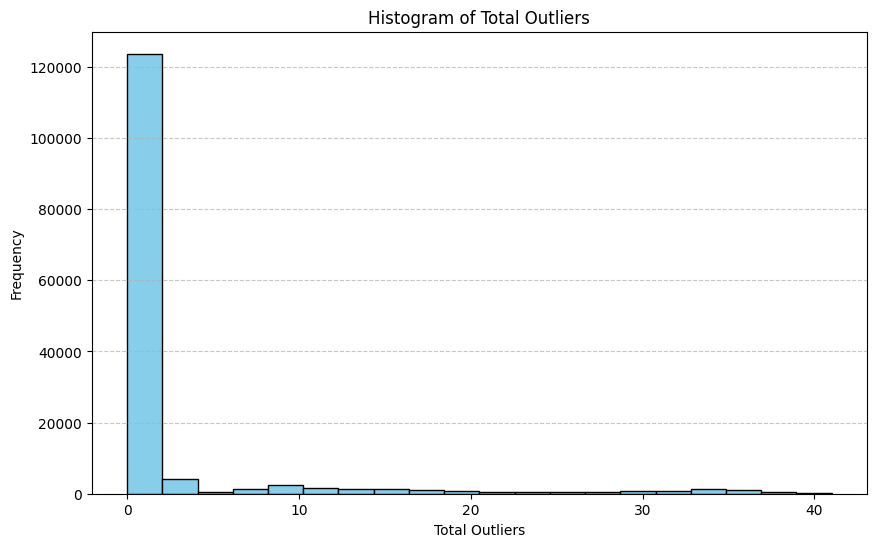

In [21]:
import matplotlib.pyplot as plt

df_pandas = df_with_outlier_handling.select("total_outliers").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_pandas["total_outliers"], bins=20, edgecolor='black', color='skyblue')
plt.title("Histogram of Total Outliers")
plt.xlabel("Total Outliers")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Remove the rows which have more than ten outliers

In [22]:
df_with_substituted_outliers = df_with_outlier_handling.\
filter(df_with_outlier_handling['total_outliers']<=10)
        
df_with_substituted_outliers = df_with_substituted_outliers.drop("total_outliers")

In [23]:
final_df  = df_with_substituted_outliers

### Correlation plot

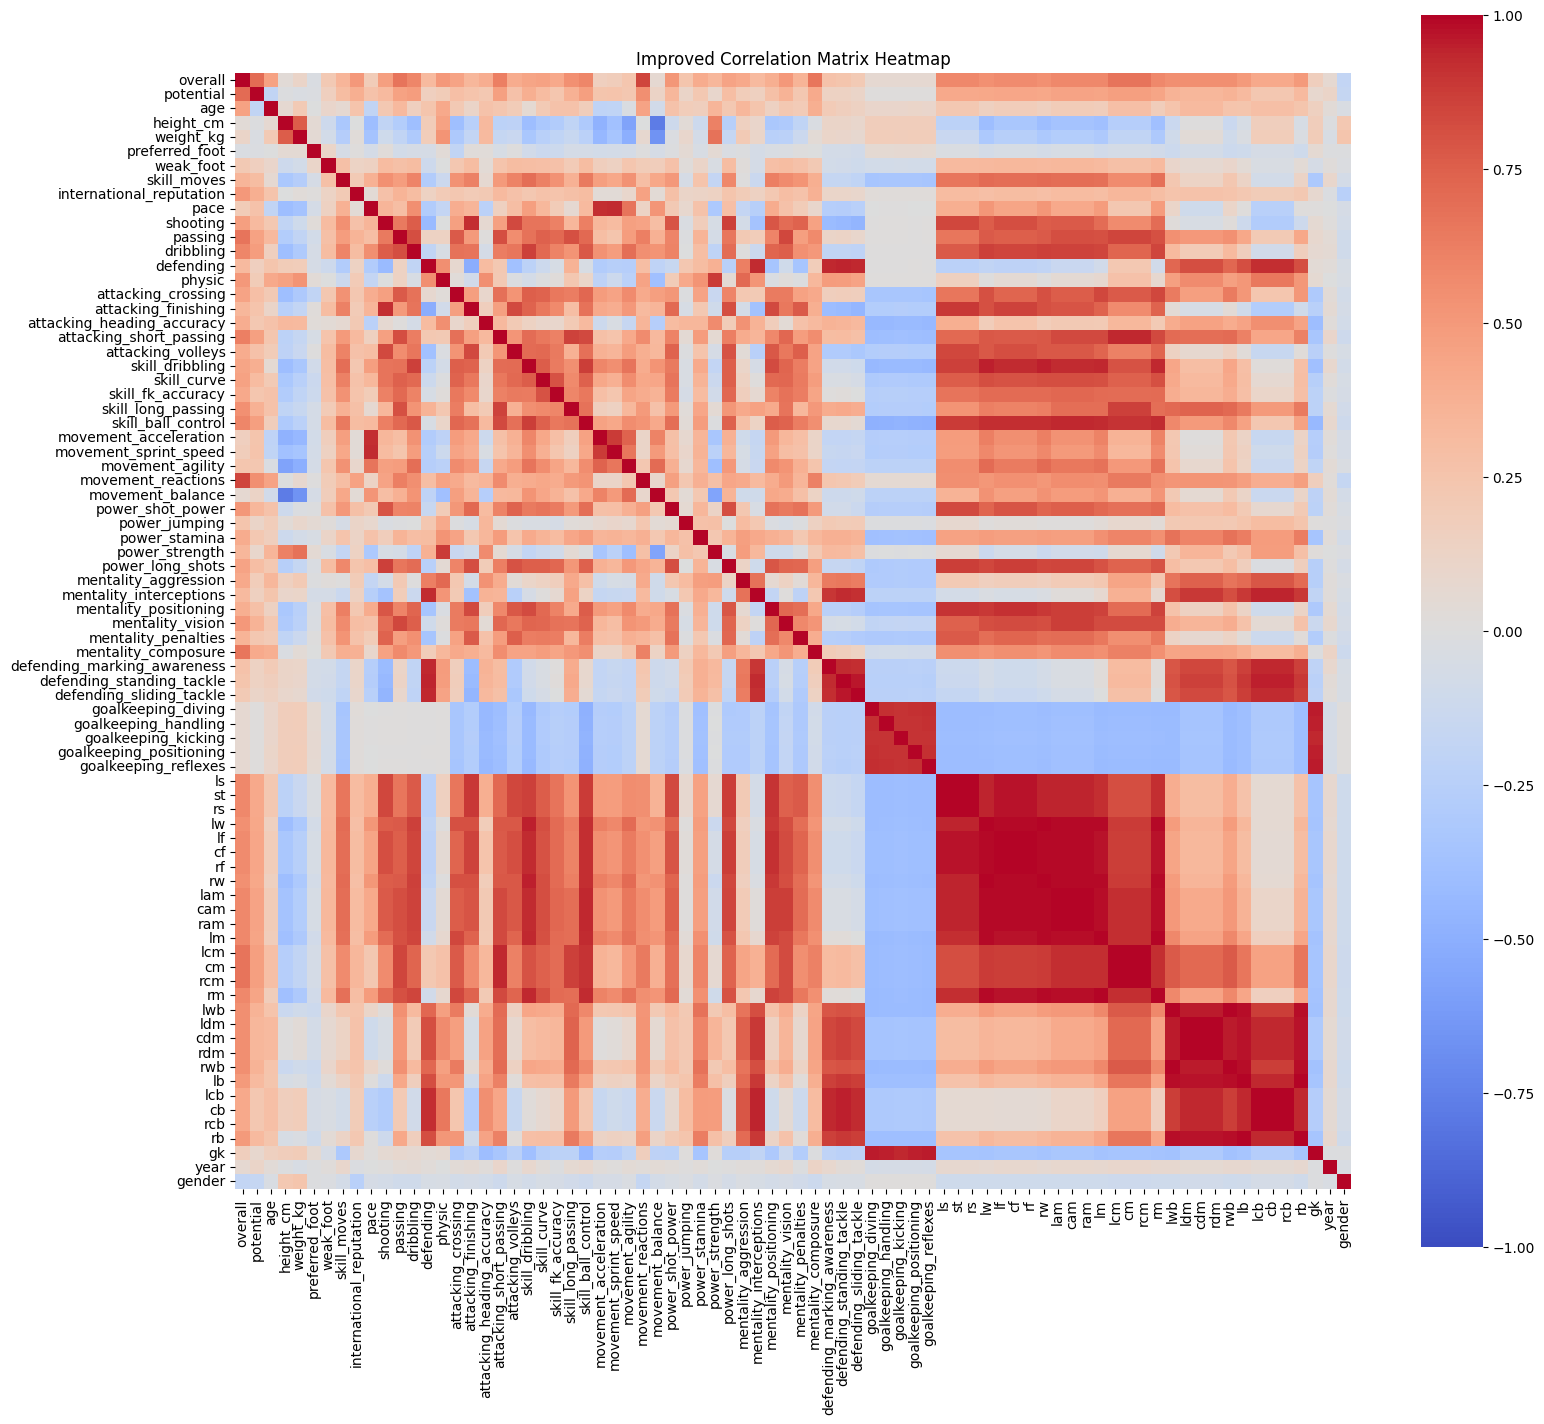

In [24]:
import seaborn as sns
correlation_matrix = final_df.toPandas().corr()
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1, annot=False, fmt=".2f", square=True)
plt.title("Improved Correlation Matrix Heatmap")
plt.show()

### Train_test split

In [25]:
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=66)

### Pipeline

In [26]:
nominal_cols = [
    "preferred_foot", "gender"
]

continuous_cols = [
    "potential", "age", "height_cm", "weight_kg",  
    "weak_foot", "skill_moves", "international_reputation", "pace", "shooting", 
    "passing", "dribbling", "defending", "physic", "attacking_crossing", 
    "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", 
    "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", 
    "skill_long_passing", "skill_ball_control", "movement_acceleration", 
    "movement_sprint_speed", "movement_agility", "movement_reactions", 
    "movement_balance", "power_shot_power", "power_jumping", "power_stamina", 
    "power_strength", "power_long_shots", "mentality_aggression", 
    "mentality_interceptions", "mentality_positioning", "mentality_vision", 
    "mentality_penalties", "mentality_composure", "defending_marking_awareness", "defending_standing_tackle", 
    "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", 
    "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes",
    "ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", 
    "lm", "lcm", "cm", "rcm", "rm", "lwb", "ldm", "cdm", "rdm", "rwb", 
    "lb", "lcb", "cb", "rcb", "rb", "gk", "year"
]

In [27]:
class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset.withColumn('target', F.col('overall').cast(DoubleType())).drop("overall")
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in continuous_cols:
            output_df = output_df.withColumn(col_name,F.col(col_name).cast(DoubleType()))

        return output_df

class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df    

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x + "_index" for x in nominal_cols]
    nominal_onehot_cols = [x + "_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols)

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols  + nominal_onehot_cols

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')

    # Stage for creating the outcome column representing the 5-class label
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columns, only keeping the 'features' and 'target' columns
    stage_column_dropper = ColumnDropper(columns_to_drop=nominal_cols + nominal_id_cols +
                                         nominal_onehot_cols  + continuous_cols + 
                                         ['vectorized_features'])

    # Connect the stages into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster, stage_nominal_indexer, stage_nominal_onehot_encoder,
                                stage_vector_assembler, stage_scaler, stage_outcome,
                                stage_column_dropper])
    
    return pipeline


In [28]:
# establish training pipeline
pipeline = get_preprocess_pipeline()

# fit the model with pipeline
preprocessing = pipeline.fit(train_data)

# make predictions on testing dataset
train_processed = preprocessing.transform(train_data)
test_processed = preprocessing.transform(test_data)

# print testing dataset pipeline
train_processed.orderBy(F.col('target').desc()).show()

+--------------------+------+
|            features|target|
+--------------------+------+
|[14.5965696050679...|  92.0|
|[14.5965696050679...|  92.0|
|[14.5965696050679...|  92.0|
|[14.5965696050679...|  92.0|
|[14.5965696050679...|  92.0|
|[14.5965696050679...|  92.0|
|[14.5965696050679...|  92.0|
|[14.5965696050679...|  92.0|
|[14.9138863356128...|  92.0|
|[15.0725447008853...|  92.0|
|[15.0725447008853...|  92.0|
|[14.4379112397954...|  91.0|
|[14.4379112397954...|  91.0|
|[14.4379112397954...|  91.0|
|[14.4379112397954...|  91.0|
|[14.4379112397954...|  91.0|
|[14.4379112397954...|  91.0|
|[14.4379112397954...|  91.0|
|[14.4379112397954...|  91.0|
|[14.4379112397954...|  91.0|
+--------------------+------+
only showing top 20 rows



In [29]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = train_processed.toPandas()

# Display the full feature list of the first row
print(len(list(pandas_df['features'][0])))
print(list(pandas_df['features'][0]))


77
[7.774259898351392, 4.828352863832153, 26.93971566238816, 10.11240869187573, 3.117895642786164, 3.0252466797282684, 2.379915273381419, 6.578945182685746, 1.9580647458988936, 2.586662224347602, 2.9240493242028767, 2.1177317199954957, 6.350353961124827, 1.532186069708584, 1.4733235632173274, 2.902615553418917, 2.874722640188902, 1.8925540331322117, 1.7070780922446487, 1.5250109078007061, 1.7429039873866743, 1.6094140406049289, 2.9600326585753733, 5.881180014726341, 6.195923271529022, 2.5951016794744537, 3.519667623695065, 4.899226418897415, 2.791393866496771, 5.53630505355947, 5.682123984469603, 5.000463780024755, 1.3379013133681052, 2.9072510753317, 1.7876582590135697, 1.7178668436178581, 1.8801978917355866, 1.5828356949663114, 6.052522737937165, 1.913624505589247, 1.7329431934120536, 1.7969291737886206, 1.4793180264935786, 1.3533690525473614, 0.6301507068815791, 1.1295686312008402, 0.8713375164238351, 3.4202409766428357, 3.4202409766428357, 3.4202409766428357, 3.031822210113763, 3.0

## Training

### Model1: Spark Linear Regression

In [30]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
model_lr = LinearRegression(featuresCol='features', labelCol='target', maxIter=100)

# Fit the model

model_lr = model_lr.fit(train_processed)
train_predictions = model_lr.transform(train_processed)
train_predictions.show()

test_predictions = model_lr.transform(test_processed)
test_predictions.show()
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="mse")
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

+--------------------+------+------------------+
|            features|target|        prediction|
+--------------------+------+------------------+
|[7.77425989835139...|  40.0| 44.05981691290134|
|[7.93291826362387...|  41.0| 40.70693110631797|
|[9.67816028162112...|  41.0|46.926453278426266|
|[8.56755172471377...|  42.0| 45.17783604804828|
|[8.88486845525873...|  42.0|49.709199978282555|
|[8.88486845525873...|  43.0|46.958242349733496|
|[7.93291826362387...|  44.0| 41.70859770689256|
|[8.25023499416882...|  44.0| 45.35849527999511|
|[8.88486845525873...|  44.0| 46.12004212237596|
|[8.88486845525873...|  44.0|  45.2167822231028|
|[9.04352682053121...|  44.0| 46.64934083161012|
|[9.04352682053121...|  44.0| 47.20086579925609|
|[9.36084355107616...|  44.0|47.152674448736434|
|[9.36084355107616...|  44.0| 48.53904210002747|
|[9.36084355107616...|  44.0|47.098030176510605|
|[9.51950191634864...|  44.0| 46.38153536976088|
|[9.51950191634864...|  44.0|48.799593711864645|
|[7.93291826362387..

### Model 2: Spark Decision Tree

In [31]:
from pyspark.ml.regression import DecisionTreeRegressor,RandomForestRegressor
model_dt = DecisionTreeRegressor(featuresCol='features', labelCol='target', maxDepth=12)

# Fit the model

model_dt = model_dt.fit(train_processed)
train_predictions = model_dt.transform(train_processed)
train_predictions.show()

test_predictions = model_dt.transform(test_processed)
test_predictions.show()
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="mse")
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Train MSE: {train_rmse:.2f}")
print(f"Test MSE: {test_rmse:.2f}")

+--------------------+------+-----------------+
|            features|target|       prediction|
+--------------------+------+-----------------+
|[7.77425989835139...|  40.0|49.57544581618656|
|[7.93291826362387...|  41.0|49.57544581618656|
|[9.67816028162112...|  41.0|49.57544581618656|
|[8.56755172471377...|  42.0|52.89793281653747|
|[8.88486845525873...|  42.0|49.57544581618656|
|[8.88486845525873...|  43.0|49.57544581618656|
|[7.93291826362387...|  44.0|49.57544581618656|
|[8.25023499416882...|  44.0|49.57544581618656|
|[8.88486845525873...|  44.0|49.57544581618656|
|[8.88486845525873...|  44.0|49.57544581618656|
|[9.04352682053121...|  44.0|49.57544581618656|
|[9.04352682053121...|  44.0|49.57544581618656|
|[9.36084355107616...|  44.0|49.57544581618656|
|[9.36084355107616...|  44.0|49.57544581618656|
|[9.36084355107616...|  44.0|49.57544581618656|
|[9.51950191634864...|  44.0|49.57544581618656|
|[9.51950191634864...|  44.0|49.57544581618656|
|[7.93291826362387...|  45.0|49.57544581

## Pytorch

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:

train_pd = train_processed.toPandas()
test_pd = test_processed.toPandas()
X_train = torch.from_numpy(np.array(train_pd['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(train_pd['target'].values, np.float32))

X_test = torch.from_numpy(np.array(test_pd['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(test_pd['target'].values, np.float32))

In [34]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False 
    
set_seed(42)

In [35]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [36]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [37]:
input_sizes = X_train.shape[1]
print(input_sizes)

77


### Model 1: Pytorch Neural Network 1

In [38]:
class FIFAmodel(nn.Module):
    def __init__(self, ):
        super().__init__()
        input_size = input_sizes
        output_size = 1
        self.lin1 = nn.Linear(input_size, 128)
        self.lin2 = nn.Linear(128, 128)
        self.lin3 = nn.Linear(128, 128)
        self.lin4 = nn.Linear(128, output_size)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.lin1(x))
        x = self.act(self.lin2(x))
        x = self.act(self.lin3(x))
        x = self.lin4(x)
        return x

In [39]:
model1 = FIFAmodel().to(device)

lr = 1e-3
batch_size = 256
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

training_loss = [] # training losses of each epoch

current_best_loss = float('inf')

In [40]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
training_loss = [] # training losses of each epoch

for epoch in range(epochs):
    training_batch_loss = []
    training_batch_accuracy = []
    for x_batch, y_batch in train_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model1(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_batch_loss.append(loss.detach().cpu().numpy()) # batch loss of training
   
    scheduler.step()
    # training and validation loss of each epoch
    training_loss.append(np.mean(np.array(training_batch_loss)))
    # printing
    if epoch%10 == 0:
        print(f"Epoch = {epoch}, training_loss = {training_loss[-1]}")

    # save the best model
    if training_loss[-1] < current_best_loss:
        torch.save(model1.state_dict(), 'fifa_best_model1.pth')
        current_best_loss = training_loss[-1]


c:\Users\User\anaconda3\envs\system_tool_course\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\User\anaconda3\envs\system_tool_course\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([91])) that is different to the input size (torch.Size([91, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch = 0, training_loss = 86.23738861083984
Epoch = 10, training_loss = 50.335872650146484
Epoch = 20, training_loss = 50.11339569091797
Epoch = 30, training_loss = 50.04011917114258
Epoch = 40, training_loss = 49.99306869506836
Epoch = 50, training_loss = 49.98604202270508
Epoch = 60, training_loss = 50.00649642944336
Epoch = 70, training_loss = 49.9588623046875
Epoch = 80, training_loss = 49.96601104736328
Epoch = 90, training_loss = 49.940704345703125


In [42]:
# load the best model back
model1.load_state_dict(torch.load('fifa_best_model1.pth'))

# Testing
test_loss = []
model1.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        test_pred = model1(x_batch)
        test_loss.append(loss_fn(test_pred, y_batch).detach().cpu().numpy())
    
    print(f"Test loss = {np.round(np.mean(test_loss))}")

C:\Users\User\AppData\Local\Temp\ipykernel_46300\22813216.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('fifa_best_model1.pth'))


Test loss = 52.0


c:\Users\User\anaconda3\envs\system_tool_course\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([151])) that is different to the input size (torch.Size([151, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Model 2: Pytorch Neural Network 2

In [43]:
class FIFAmodel2(nn.Module):
    def __init__(self, ):
        super().__init__()
        input_size = input_sizes
        output_size = 1
        self.lin1 = nn.Linear(input_size, 512)
        self.lin2 = nn.Linear(512, 512)
        self.lin3 = nn.Linear(512, 512)
        self.lin4 = nn.Linear(512, 512)
        self.lin5 = nn.Linear(512, 512)
        self.lin6 = nn.Linear(512, 512)
        self.lin7 = nn.Linear(512, 512)
        self.lin8 = nn.Linear(512, 512)
        self.lin9 = nn.Linear(512, output_size)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.lin1(x))
        x = self.act(self.lin2(x))
        x = self.act(self.lin3(x))
        x = self.act(self.lin4(x))
        x = self.act(self.lin5(x))
        x = self.act(self.lin6(x))
        x = self.act(self.lin7(x))
        x = self.act(self.lin8(x))
        x = self.lin9(x)
        return x

In [44]:
model2 = FIFAmodel2().to(device)

lr = 1e-3
batch_size = 256
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

training_loss = [] # training losses of each epoch

current_best_loss = float('inf')

In [45]:
training_loss = [] # training losses of each epoch

for epoch in range(epochs):
    training_batch_loss = []
    for x_batch, y_batch in train_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model2(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_batch_loss.append(loss.detach().cpu().numpy()) # batch loss of training
   
    scheduler.step()
    # training and validation loss of each epoch
    training_loss.append(np.mean(np.array(training_batch_loss)))
    # printing
    if epoch%10 == 0:
        print(f"Epoch = {epoch}, training_loss = {training_loss[-1]}")

    # save the best model2
    if training_loss[-1] < current_best_loss:
        torch.save(model2.state_dict(), 'fifa_best_model2.pth')
        current_best_loss = training_loss[-1]


Epoch = 0, training_loss = 93.60999298095703
Epoch = 10, training_loss = 51.62406921386719
Epoch = 20, training_loss = 50.58586502075195
Epoch = 30, training_loss = 50.134944915771484
Epoch = 40, training_loss = 50.075645446777344
Epoch = 50, training_loss = 49.9895133972168
Epoch = 60, training_loss = 49.94478988647461
Epoch = 70, training_loss = 49.986995697021484
Epoch = 80, training_loss = 49.9784049987793
Epoch = 90, training_loss = 49.97675323486328


In [46]:
# load the best model2 back
model2.load_state_dict(torch.load('fifa_best_model2.pth'))

# Testing
test_loss = []
model2.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        test_pred = model2(x_batch)
        test_loss.append(loss_fn(test_pred, y_batch).detach().cpu().numpy())
    
    print(f"Test loss = {np.round(np.mean(test_loss))}")

C:\Users\User\AppData\Local\Temp\ipykernel_46300\2659235609.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('fifa_best_model2.pth'))


Test loss = 52.0
